# Well log plots  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

The purpose of this notebook is to plot the logs of the training data to see if we can tease out any qualitative information.  This may lead to the development of additional quantitative features based on the logs we presently have.  Let's go!

In [2]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

In [8]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# convert NM_M channel into a binary channel "isMarine"
data$NM_M <- data$NM_M == "2"
names(data)[10] <- "isMarine"

# make the Facies channel more descriptive
levels(data$Facies) <- c("SS", "CSiS", "FSiS", "SiSh", "MS", "WS", "D", "PS", "BS")

# split out SHANKLE well as test set into 'blind' data frame
test_index <- data$Well.Name == "SHANKLE"
blind <- data[test_index,]
data <- data[!test_index,]

# display first five rows of data set
head(data)
unique(data$Well.Name)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,isMarine,RELPOS
FSiS,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,FALSE,1.000
FSiS,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,FALSE,0.979
FSiS,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,FALSE,0.957
FSiS,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,FALSE,0.936
FSiS,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,FALSE,0.915
FSiS,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,FALSE,0.894


[1] SHRIMPLIN       ALEXANDER D     LUKE G U        KIMZEY A       
[5] CROSS H CATTLE  NOLAN           Recruit F9      NEWBY          
[9] CHURCHMAN BIBLE
10 Levels: ALEXANDER D CHURCHMAN BIBLE CROSS H CATTLE KIMZEY A ... SHRIMPLIN

It's worth noting that both the **ALEXANDER D** and **KIMZEY A** wells do not have **PE** data.  In previously made notebooks, these wells were excluded from the training data.  We will include them here - as this is primarily a visualization notebook.  Let's build functions which plot each feature!

In [76]:
facies_colors <- c('#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D')
facies_labels <- c('SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS')

# GR track - gamma ray
plotGR <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) + 
        scale_y_continuous(lim=c(0,400), breaks=seq(0,400,100), labels=c("0"="0","100"="","200"="200","300"="","400"="400")) +
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="Depth", y="GR") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=GR, fill=GR, alpha=0.5), width=0.5) +
        geom_line(aes(x=Depth, y=GR), lwd=.5, col='black') +
        scale_fill_continuous(limits=c(0,225), low="yellow", high="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.5), legend.position="none",
             axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"))
    if (asWell) {g <- g + labs(y=x$Well.Name[1])}
    if (asWell & x$Well.Name[1] != "SHRIMPLIN") {g <- g + labs(x="")}
    g <- switch_axis_position(g, 'x')
    g
}

# ILD track - resistivity
plotILD <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_log10(lim=c(0.1,50), breaks=c(.1,.2,.4,.6,.8,1,2,4,6,8,10,20,40), 
                      labels=c(".1"=".1",".2"="",".4"="",".6"="",".8"="",
                               "1"="1","2"="","4"="","6"="","8"="","10"="10",
                              "20"="","40"="")) + 
        scale_x_continuous(trans="reverse") + 
        coord_flip() + labs(title="", x="", y="ILD") +
        geom_line(aes(x=Depth, y=10^ILD_log10), lwd=.5, col="skyblue4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# DeltaPhi track - difference between density and neutron porosities
plotDeltaPHI <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-20,20), breaks=seq(-20,20,10),labels=c("-20"="-20","-10"="","0"="0","10"="","20"="20")) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y="DeltaPhi") +
        geom_line(aes(x=Depth, y=DeltaPHI), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# PHIND track - neutron porosity
plotPHIND <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,50), breaks=c(0,15,30,45)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PHIND") +
        geom_line(aes(x=Depth, y=PHIND), lwd=.5, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# PE track - photoelectric effect
plotPE <- function(x, asWell=F) {
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,8), breaks=c(0,2,4,6,8)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PE") +
        geom_line(aes(x=Depth, y=PE), lwd=.5, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# isMarine track - indicator showing whether or not it's marine
plotIsMarine <- function(x, asWell=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("TRUE"="", "FALSE"="")) + 
        scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="isMarine") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=isMarine), width=0.5) +
        scale_fill_manual(values=c("TRUE"="springgreen3", "FALSE"="firebrick"), drop=F) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="none")
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    g <- switch_axis_position(g, 'x')
    g
}

# facies track
plotFacies <- function(x, asWell=F) {
    x$ones <- rep(1, nrow(x))
    g <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="Facies") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Facies), width=0.5) +
        scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6), 
              legend.position="right", legend.text=element_text(size=6), legend.title=element_blank())
    if (asWell) {g <- g + labs(y=x$Well.Name[1]) + theme(axis.text.y=element_text(size=6))}
    if (asWell & x$Well.Name[1] == "SHRIMPLIN") {g <- g + labs(x="Depth")}
    if (asWell & x$Well.Name[1] != "CHURCHMAN BIBLE") {g <- g + theme(legend.position="none")}
    g <- switch_axis_position(g, 'x')
    g
}

Now let's build functions which build well log plots with/without the **PE** photoelectric effect feature.

In [51]:
# for wells with PE track
logplot_withPE <- function(x) {
    GR <- plotGR(x)
    ILD <- plotILD(x)
    deltaPHI <- plotDeltaPHI(x)
    PHIND <- plotPHIND(x)
    PE <- plotPE(x)
    isMarine <- plotIsMarine(x)
    facies <- plotFacies(x)
    
    g <- plot_grid(GR, ILD, deltaPHI, PHIND, PE, isMarine, facies, ncol=7, rel_widths=c(4,3,3,3,3,2,5))
    ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)
}

# for wells without PE track
logplot_noPE <- function(x) {
    GR <- plotGR(x)
    ILD <- plotILD(x)
    deltaPHI <- plotDeltaPHI(x)
    PHIND <- plotPHIND(x)
    isMarine <- plotIsMarine(x)
    facies <- plotFacies(x)
    
    g <- plot_grid(GR, ILD, deltaPHI, PHIND, isMarine, facies, ncol=6, rel_widths=c(4,3,3,3,2,4))
    ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)
}

Now let's plot some well logs!

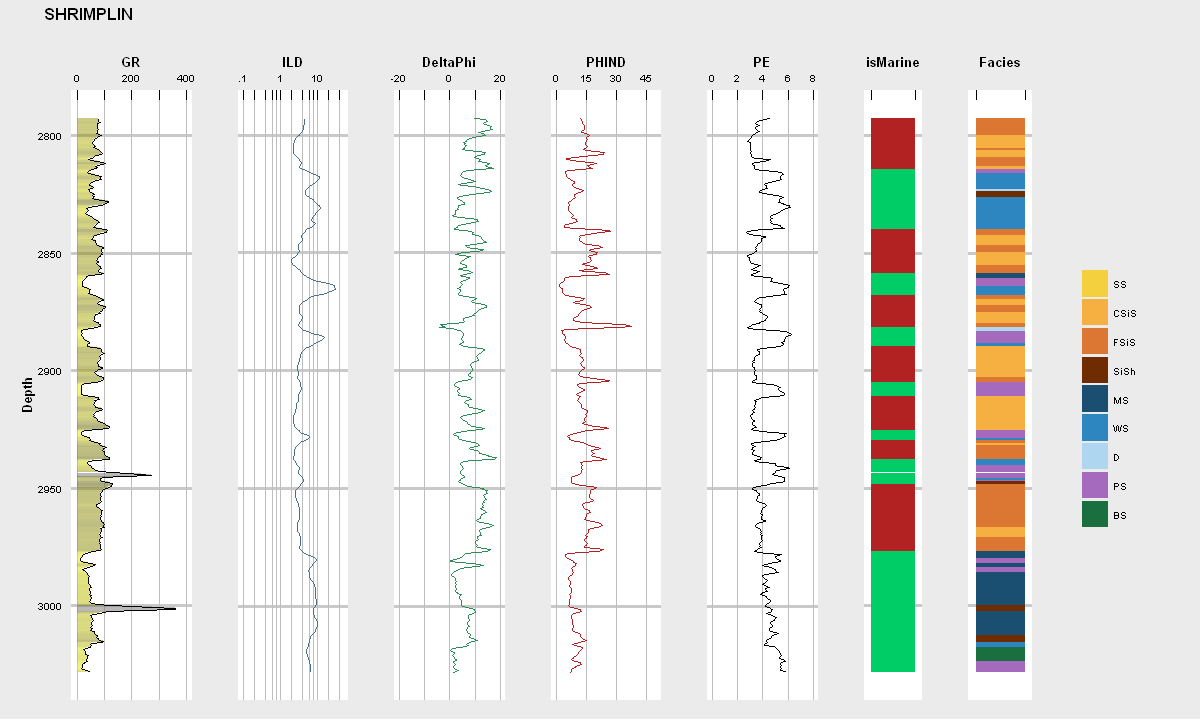

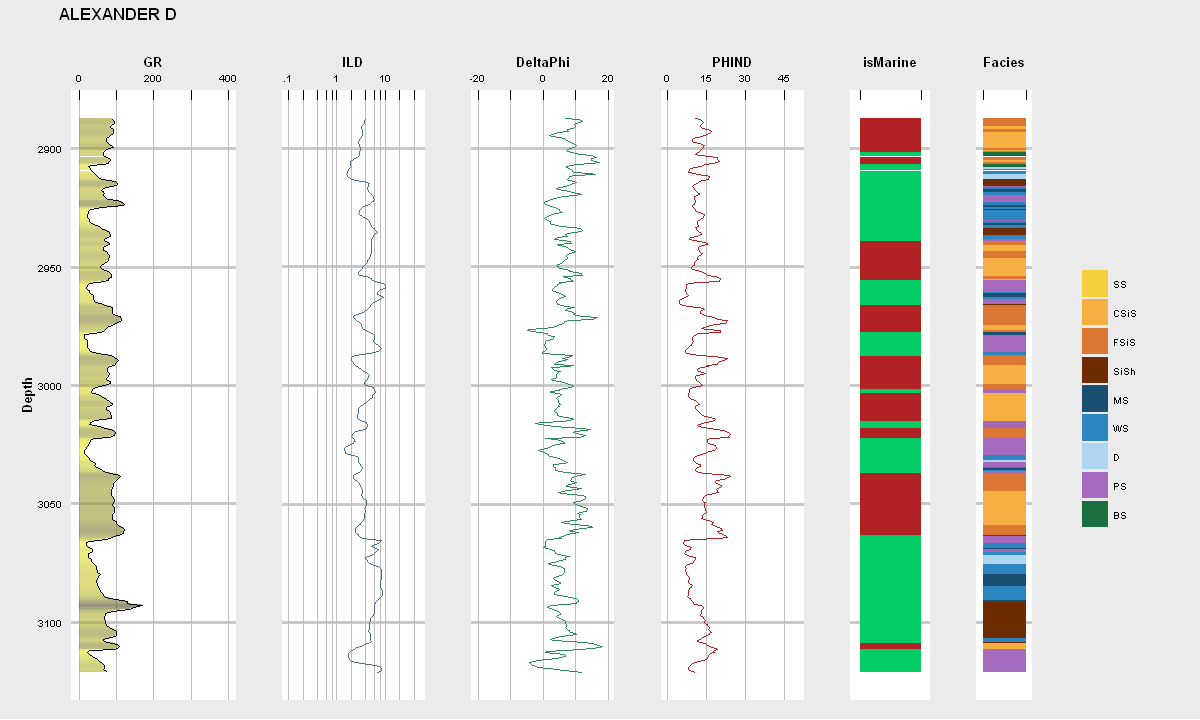

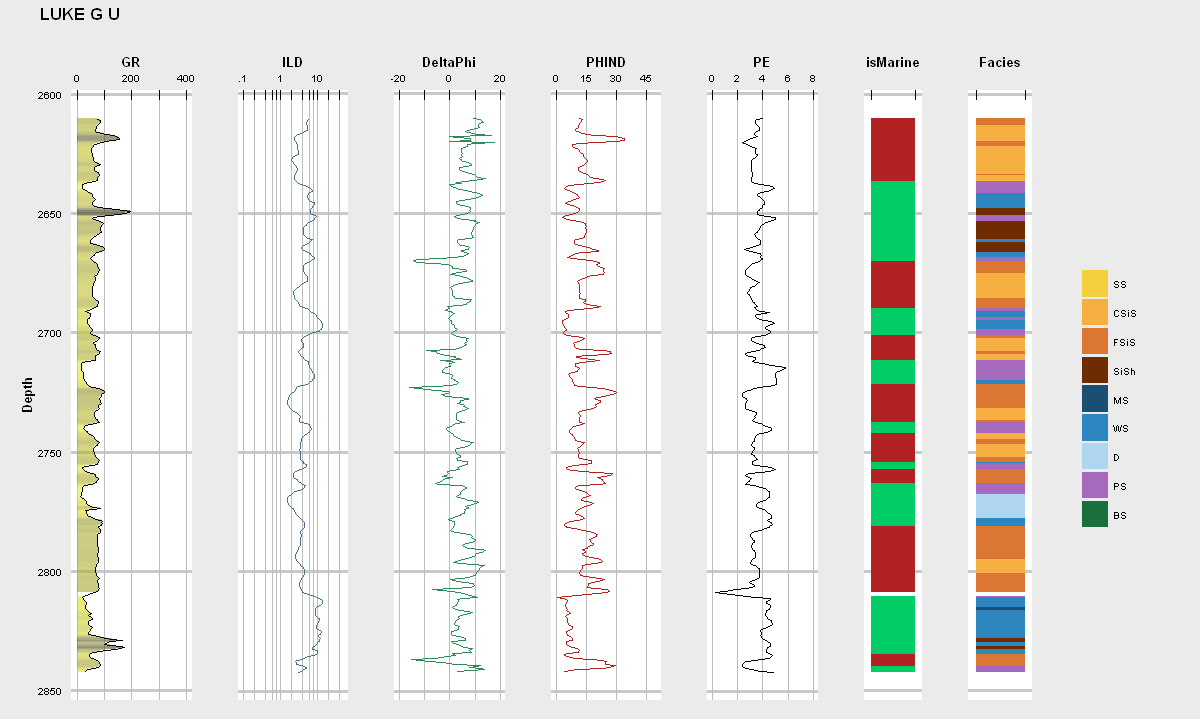

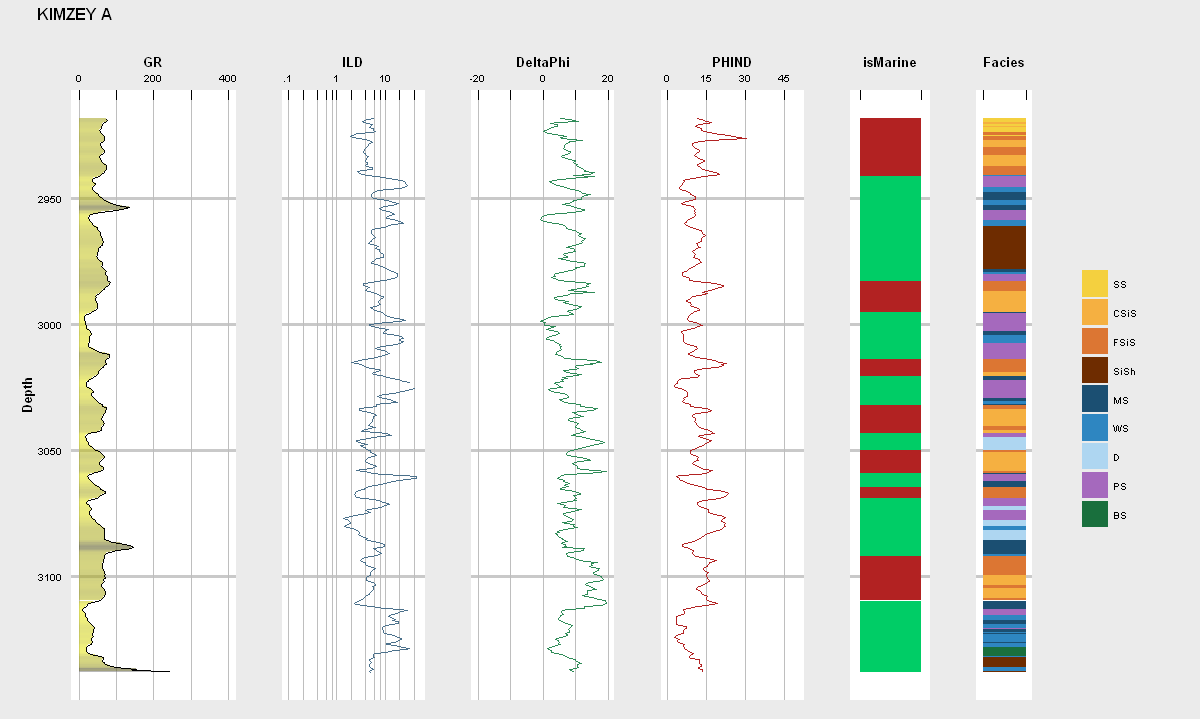

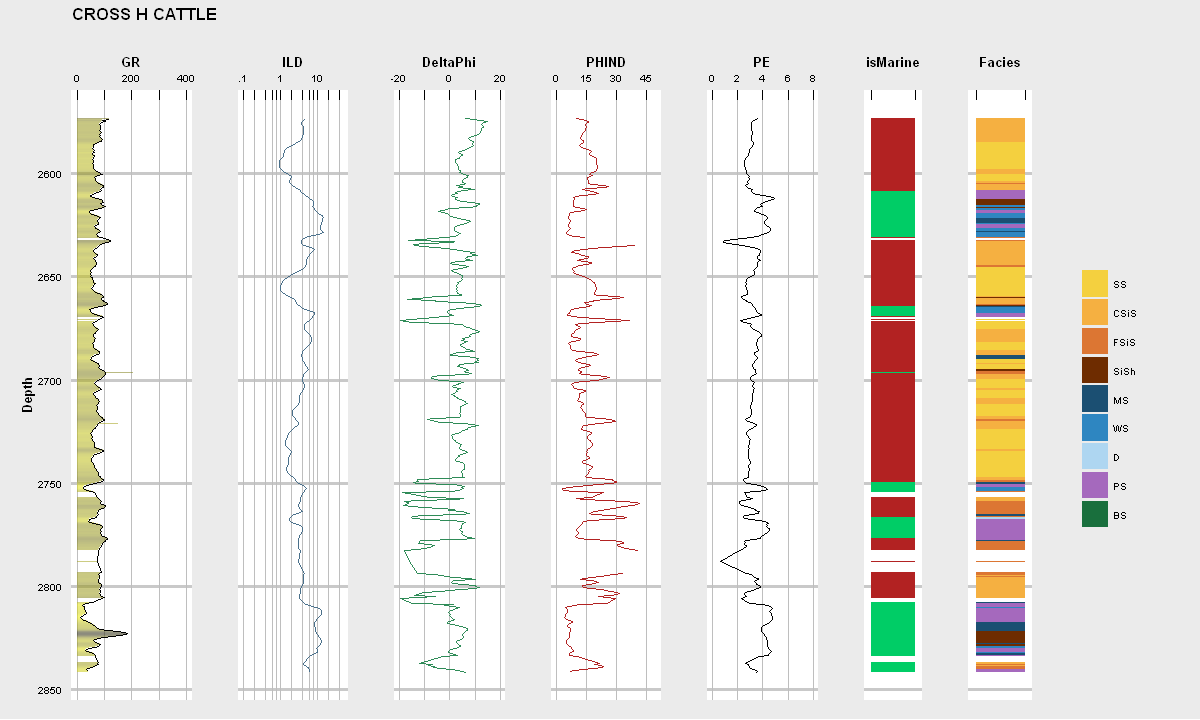

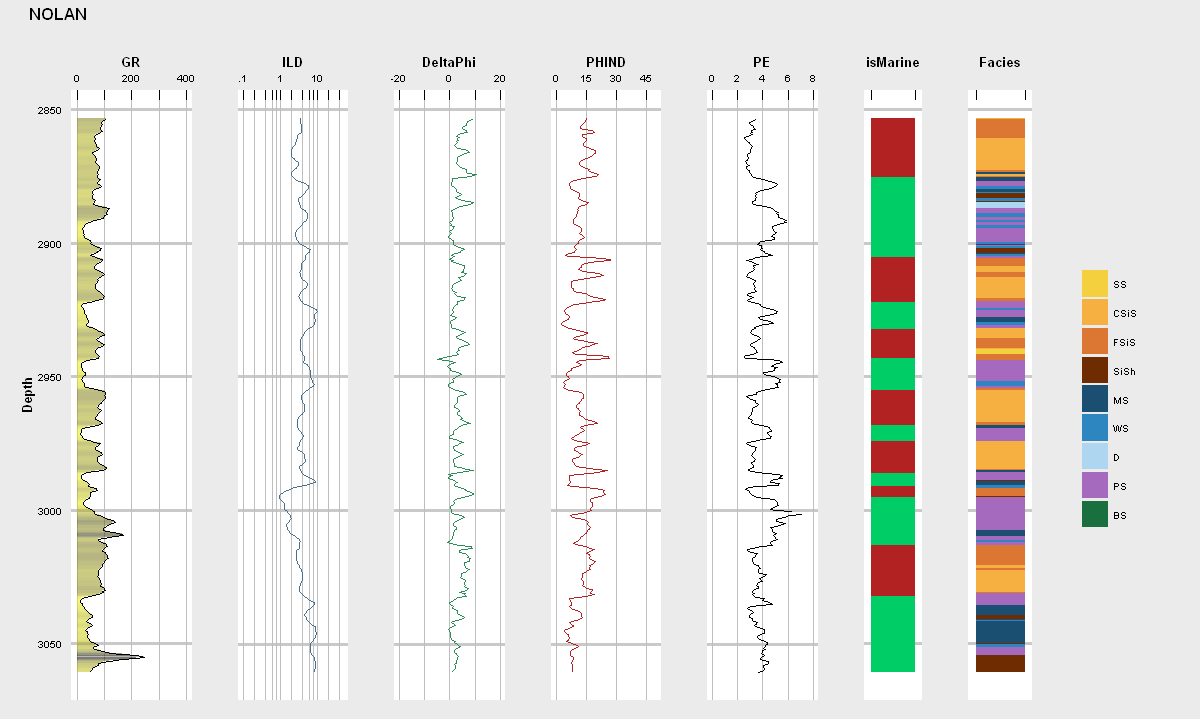

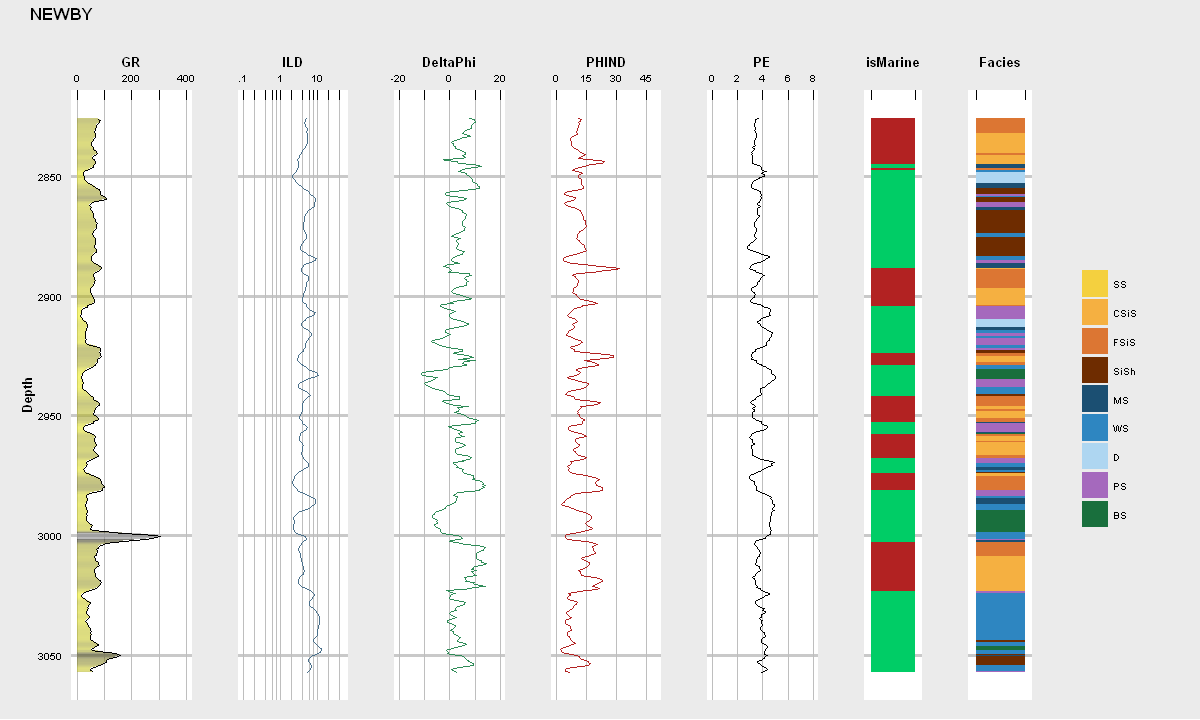

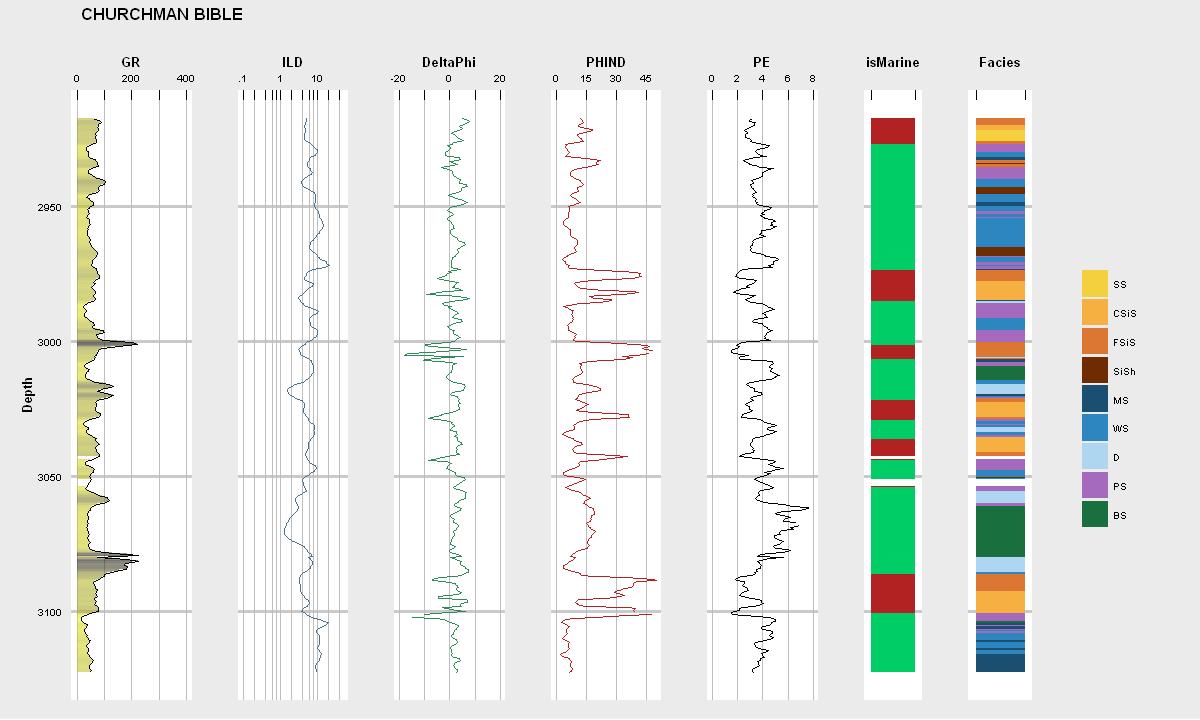

In [52]:
options(repr.plot.width=10, repr.plot.height=6)

# plot logs for the Shrimplin and Shankle wells
logplot_withPE(data[data$Well.Name == "SHRIMPLIN",])
logplot_noPE(data[data$Well.Name == "ALEXANDER D",])
logplot_withPE(data[data$Well.Name == "LUKE G U",])
logplot_noPE(data[data$Well.Name == "KIMZEY A",])
logplot_withPE(data[data$Well.Name == "CROSS H CATTLE",])
logplot_withPE(data[data$Well.Name == "NOLAN",])
logplot_withPE(data[data$Well.Name == "NEWBY",])
logplot_withPE(data[data$Well.Name == "CHURCHMAN BIBLE",])

Fancy that!  Don't those look pretty!  Now let's try another visualization approach - wherein each plot shows the same log for each well side-by-side (i.e. the GR log for each well on a single plot).  This may give us an idea of the similarities and differences between the different wells.

In [85]:
# SHRIMPLIN ALEXANDER D LUKE G U KIMZEY A CROSS H CATTLE NOLAN Recruit F9 NEWBY CHURCHMAN BIBLE

wellplot <- function(x, fxn, title, isPE=F, isFacies=F) {
    g1 <- fxn(x[x$Well.Name == "SHRIMPLIN",], T)
    if (!isPE) {g2 <- fxn(x[x$Well.Name == "ALEXANDER D",], T)}
    g3 <- fxn(x[x$Well.Name == "LUKE G U",], T)
    if (!isPE) {g4 <- fxn(x[x$Well.Name == "KIMZEY A",], T)}
    g5 <- fxn(x[x$Well.Name == "CROSS H CATTLE",], T)
    g6 <- fxn(x[x$Well.Name == "NOLAN",], T)
    g7 <- fxn(x[x$Well.Name == "NEWBY",], T)
    g8 <- fxn(x[x$Well.Name == "CHURCHMAN BIBLE",], T)
    
    if (isPE) {
        g <- plot_grid(g1, g3, g5, g6, g7, g8, ncol=6)
    }
    else if (isFacies) {
        g <- plot_grid(g1, g2, g3, g4, g5, g6, g7, g8, ncol=8, rel_widths=c(3.25,3,3,3,3,3,3,6.5))
    }
    else {
        g <- plot_grid(g1, g2, g3, g4, g5, g6, g7, g8, ncol=8)
    }
    
    ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(title, size=10)
}

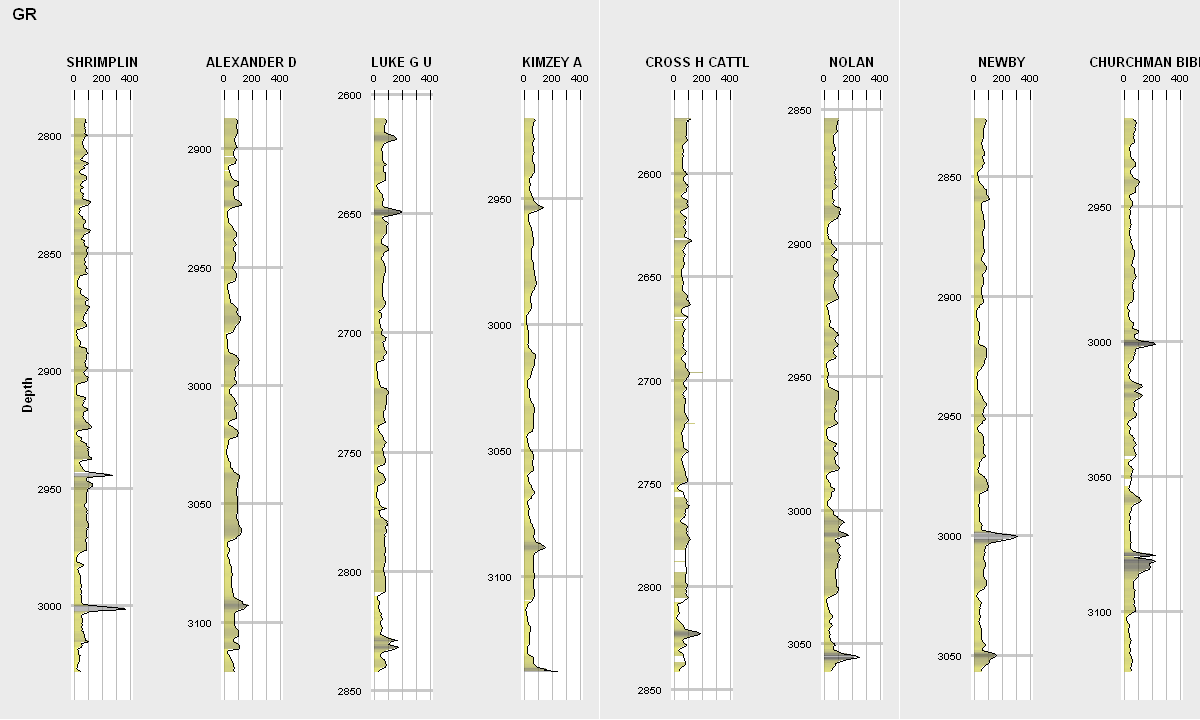

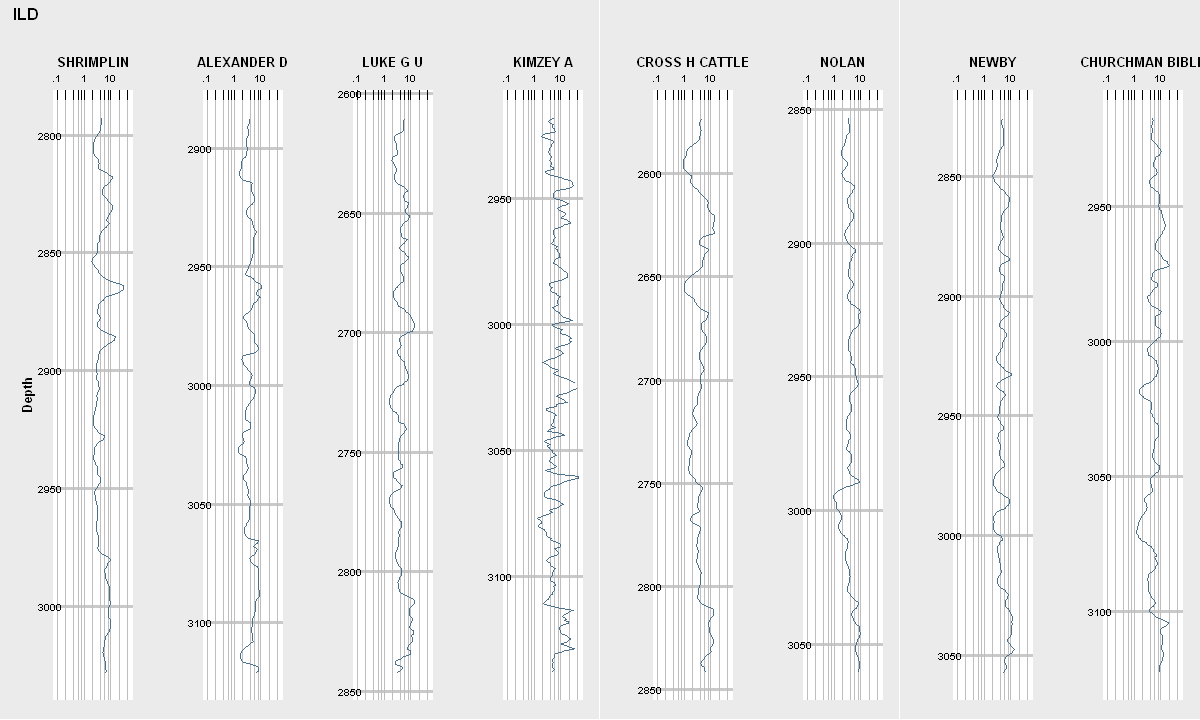

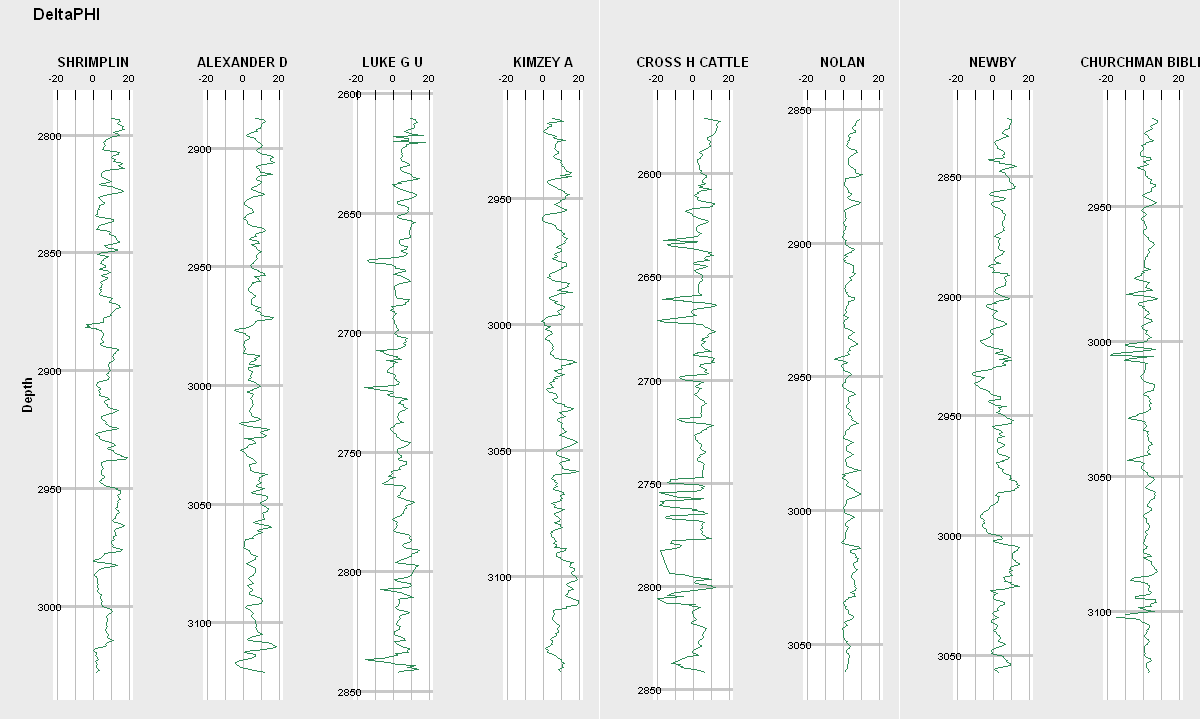

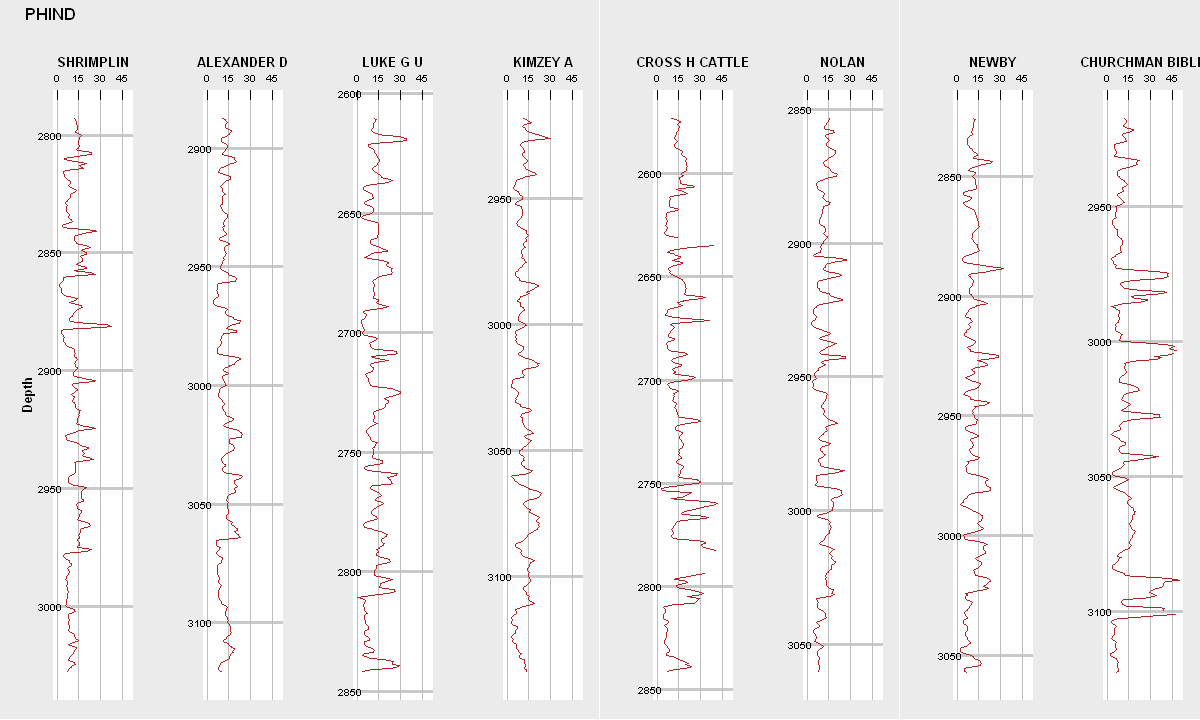

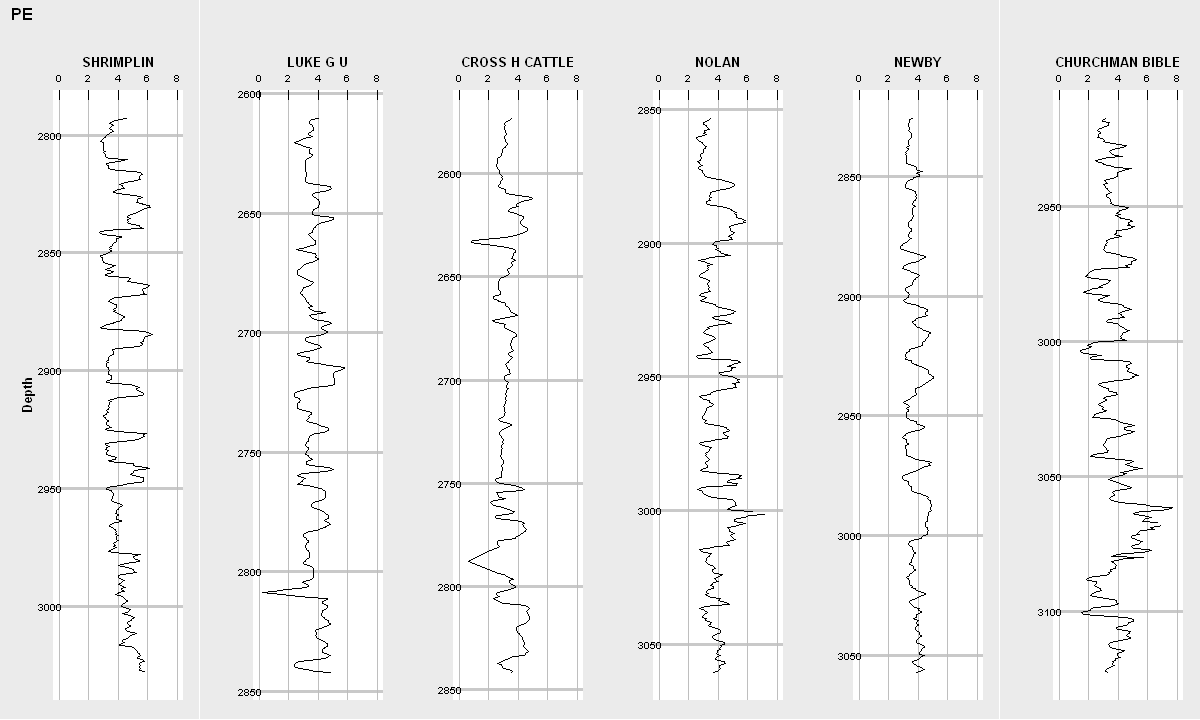

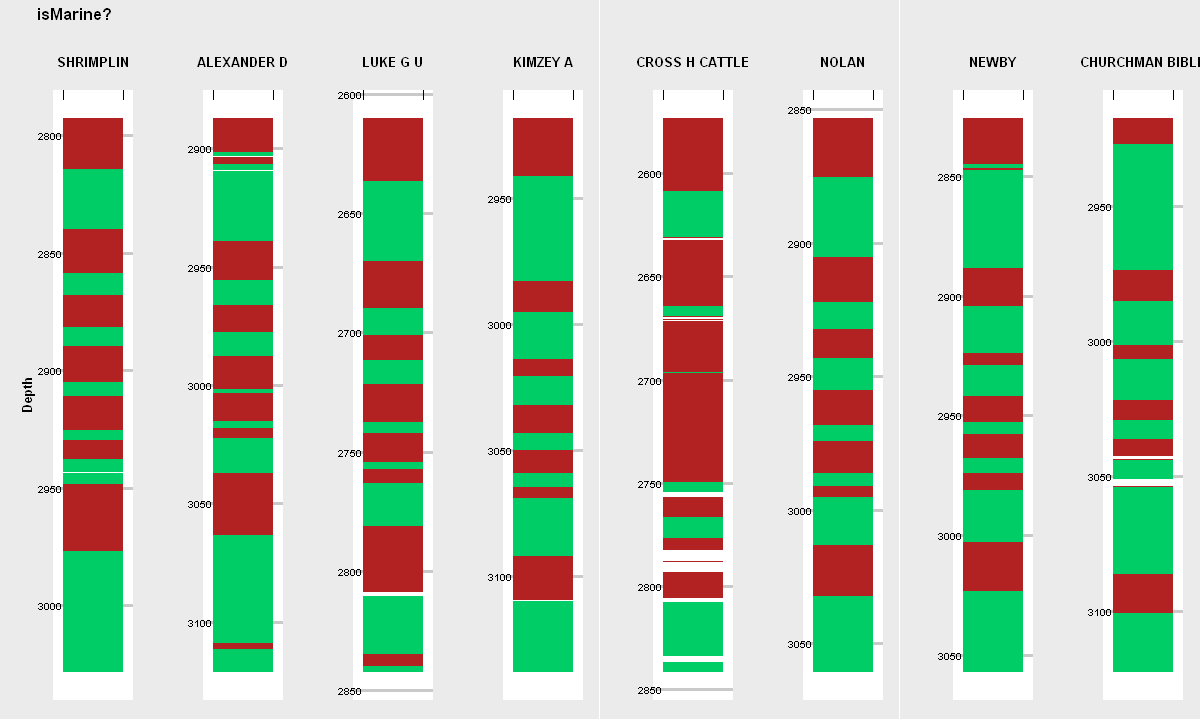

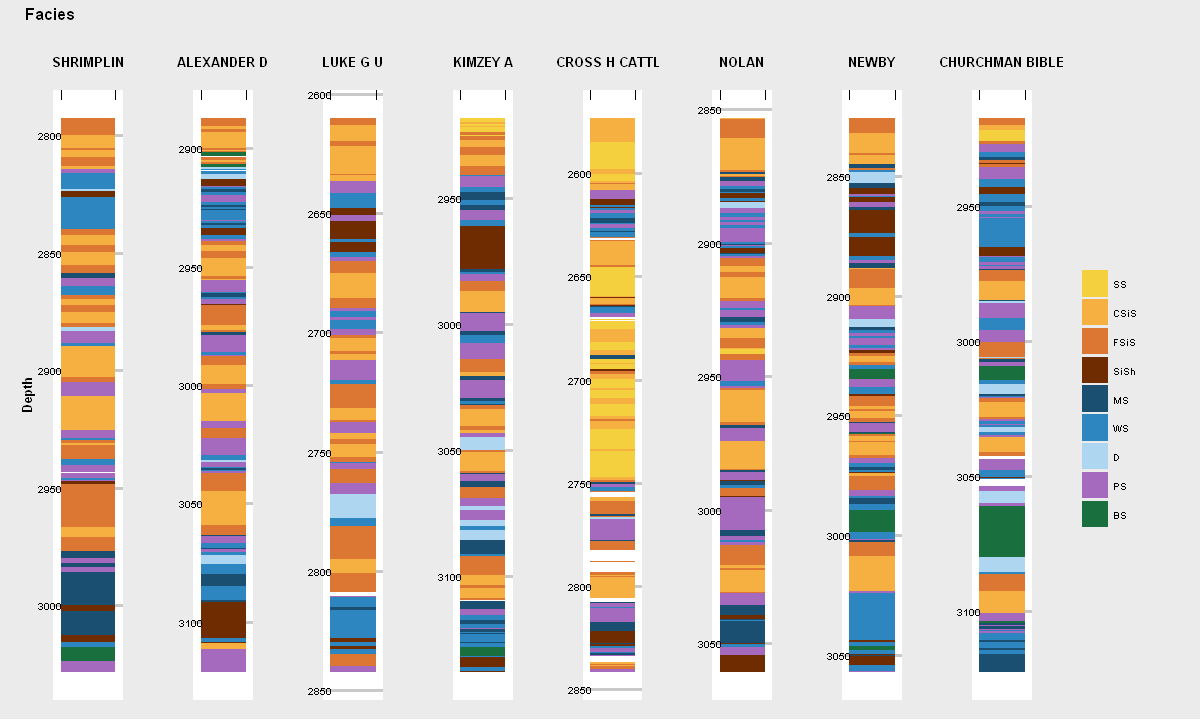

In [88]:
wellplot(data, plotGR, "GR")
wellplot(data, plotILD, "ILD")
wellplot(data, plotDeltaPHI, "DeltaPHI")
wellplot(data, plotPHIND, "PHIND")
wellplot(data, plotPE, "PE", isPE=T)
wellplot(data, plotIsMarine, "isMarine?")
wellplot(data, plotFacies, "Facies", isFacies=T)

It's interesting how different the **Cross H Cattle** well appears to have a much different character.  This is especially notable in the **isMarine** feature.